<h1 align="center" style="color:Gray">Neural Network Visualizer Web App with Streamlit and Python</h1>

![](Decorator/Neural_Network_Visualizer_Front.png)

 ***

## Import Libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyterlab/conda/envs/python/lib/python3

## Download Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Plot Example

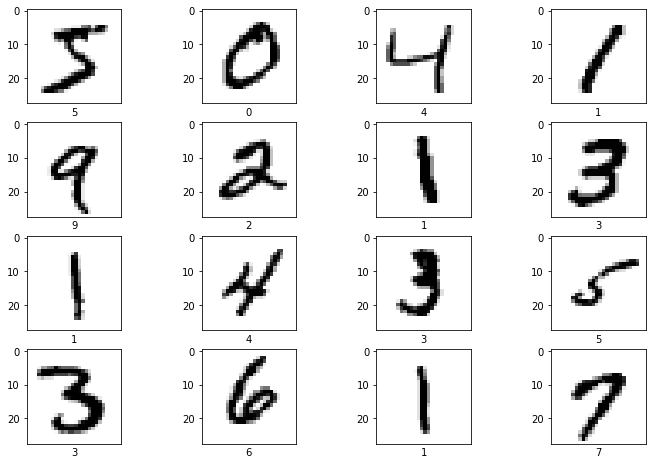

In [3]:
plt.figure(figsize=(12,8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks=([])
plt.show()

## Normalize Data

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = np.reshape(x_train, (60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

#change the pixal size from 0-255 to 0-1
x_train = x_train/255.0
x_test = x_test/255.0

In [6]:
x_train.shape

(60000, 784)

## Create a Nural Network Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Train the Model

In [8]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=512,
    verbose=2
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 2.0529 - acc: 0.4906 - val_loss: 1.6828 - val_acc: 0.7372
Epoch 2/20
 - 6s - loss: 1.3485 - acc: 0.7866 - val_loss: 1.0292 - val_acc: 0.8472
Epoch 3/20
 - 6s - loss: 0.8365 - acc: 0.8623 - val_loss: 0.6665 - val_acc: 0.8866
Epoch 4/20
 - 6s - loss: 0.5764 - acc: 0.8894 - val_loss: 0.4897 - val_acc: 0.9010
Epoch 5/20
 - 5s - loss: 0.4441 - acc: 0.9021 - val_loss: 0.3966 - val_acc: 0.9102
Epoch 6/20
 - 5s - loss: 0.3691 - acc: 0.9115 - val_loss: 0.3387 - val_acc: 0.9183
Epoch 7/20
 - 5s - loss: 0.3212 - acc: 0.9191 - val_loss: 0.3003 - val_acc: 0.9242
Epoch 8/20
 - 6s - loss: 0.2881 - acc: 0.9246 - val_loss: 0.2740 - val_acc: 0.9277
Epoch 9/20
 - 6s - loss: 0.2633 - acc: 0.9292 - val_loss: 0.2533 - val_acc: 0.9314
Epoch 10/20
 - 6s - loss: 0.2438 - acc: 0.9340 - val_loss: 0.2379 - val_acc: 0.9346
Epoch 11/20
 - 7s - loss: 0.2282 - acc: 0.9373 - val_loss: 0.2247 - val_acc: 0.9369
Epoch 12/20
 - 6s - loss: 0.2148 - 

## Save the Model

In [9]:
model.save('model.h5')

## ML Server

In [10]:
#model_server <POST> web app

In [11]:
%%writefile ml_server.py

import json

import tensorflow as tf
import numpy as np
import os
import random
import string

#!conda install -c conda-forge flask --yes
from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('Neural_Network_Visualizer_Web_App_with_Python/model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)
_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test/255.0

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET','POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction': final_preds,
            'image': image.tolist()
        })
        
    return 'Welcome to the model server!'

if __name__ == '__main__':
    app.run()
    

Overwriting ml_server.py


## Streamlit Web App

In [12]:
%%writefile app.py

#!pip install streamlit
import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import os

URI = 'http://127.0.0.1:5000'

st.title('Nural Network Visualizer')
st.sidebar.markdown('# Input Image')

if st.button('Get random prediction'):
    response = requests.post(URI, data={})
    response = json.load(response.text)
    pred = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28*28))
    
    st.sidebar.image(image, width=150)
    
    for layer, p in enumerate(preds):
        
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize=(32,4))
        
        if layer ==2:
            row=1
            col=10
        else:
            row=2
            col=16
        for i, number in enumerate(numbers):
            plt.subplot(row, col, i+1)
            plt.imshow((number * np.ones((8, 8, 3))).astype('float32'), cmap='binary')
            plt.xticks([])
            plt.yticks([])
            
            if layer==2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()

Overwriting app.py


## **Sample Output Application**
![](Decorator/Neural_Network_Visualizer_Sample.png)

***
<h1 align="center"><del>END</del></h1>